In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.nn import functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from prodigyopt import Prodigy

# 定义模型
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, categorical_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, categorical_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

class Decoder(nn.Module):
    def __init__(self, categorical_dim, hidden_dim_1, hidden_dim_2, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(categorical_dim, hidden_dim_2)
        self.fc2 = nn.Linear(hidden_dim_2, hidden_dim_1)
        self.fc3 = nn.Linear(hidden_dim_1, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # 确保输出在[0,1]范围内
        return x

def gumbel_softmax(logits, temperature):
    gs = F.gumbel_softmax(logits, tau=temperature, hard=False, eps=1e-5, dim=-1)
    return gs


In [2]:
def train_and_plot(dataset_name, hidden_dim_1, hidden_dim_2, batch_size, epochs, initial_lr, temperature, final_temperature):
    # 加载数据
    transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
    if dataset_name == "MNIST":
        dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    elif dataset_name == "FashionMNIST":
        dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
    elif dataset_name == "EMNIST":
        dataset = datasets.EMNIST('./data', train=True, download=True, transform=transform, split='balanced')
    dataset_img_size = dataset[0][0].shape[0]
    # get the number of classes
    classes = []
    for _, label in dataset:
        if label not in classes:
            classes.append(label)
    num_classes = len(classes)
    categorical_dim = num_classes
    input_dim = output_dim = dataset_img_size

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    annealing_rate = (temperature - final_temperature) / (epochs * len(dataloader))

    # 创建模型
    encoder = Encoder(input_dim, hidden_dim_1, hidden_dim_2, categorical_dim)
    decoder = Decoder(categorical_dim, hidden_dim_1, hidden_dim_2, output_dim)

    # Optimizer & Scheduler
    # optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=initial_lr)
    optimizer = Prodigy(list(encoder.parameters()) + list(decoder.parameters()), lr=initial_lr)
    scheduler = CosineAnnealingLR(optimizer, T_max=(len(dataloader) * epochs / 4), eta_min=1e-5)

    # initialize the loss lists
    recon_losses = []
    kl_losses = []
    total_losses = []
    lr_list = []
    temperature_list = []

    # initialize the progress bar
    progress_bar = tqdm(total=(len(dataloader) * epochs), desc="Training Progress")

    # train the model
    for epoch in range(epochs):
        for batch in dataloader:
            x, labels_in_batch = batch
            x = x.view(-1, input_dim)  # 确保x的形状
            logits = encoder(x)
            z = gumbel_softmax(logits, temperature)
            x_recon = decoder(z)

            # calculate the losses
            try:
                recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum') / x.shape[0]
            except:
                # print('------------------ Error ------------------')
                # print(f'x_recon: {x_recon}, \nx: {x}, \nx_recon.shape: {x_recon.shape}, x.shape: {x.shape}\n')
                # print(f'logits: {logits}, \nz: {z}, \nlogits.shape: {logits.shape}, z.shape: {z.shape}\n')
                # print('------------------ Error ------------------')
                break
            log_softmax_logits = F.log_softmax(logits, dim=-1)
            uniform_distribution = torch.ones_like(log_softmax_logits) * (1.0 / categorical_dim)
            one_hot_labels = torch.zeros_like(log_softmax_logits).scatter_(1, labels_in_batch.unsqueeze(1), 1.0)
            kl_loss = F.kl_div(log_softmax_logits, one_hot_labels, reduction='sum') / batch_size
            loss = recon_loss + kl_loss

            # gradient descent & backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # log the losses
            recon_losses.append(recon_loss.item())
            kl_losses.append(kl_loss.item())
            total_losses.append(loss.item())
            lr_list.append(scheduler.get_last_lr()[0])
            temperature_list.append(temperature)

            # update the progress bar
            progress_bar.set_description(f'Epoch: {epoch+1}/{epochs} | Re.Loss: {recon_loss.item():.7f}, KL.Loss: {kl_loss.item():.7f} | Lr: {scheduler.get_last_lr()[0]:.7f} Temp: {temperature:.7f}', refresh=True)
            progress_bar.update(1)

            scheduler.step()  # update the learning rate
            temperature -= annealing_rate # update the temperature
            temperature = max(temperature, final_temperature)  # make sure the temperature is not lower than the minimum value

        # scheduler.step()  
        # temperature -= annealing_rate 
        # temperature = max(temperature, final_temperature)  

    progress_bar.close()

    # plot the losses curve
    plt.plot(recon_losses, label='Reconstruction Loss')
    plt.plot(kl_losses, label='KL Divergence Loss')
    plt.plot(total_losses, label='Total Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # plot the lr curve
    plt.plot(lr_list, label='lr')
    plt.show()

    # plot the temperature curve
    plt.plot(temperature_list, label='Temperature')
    plt.show()

    return dataset, encoder, decoder

# dataset_name = "MNIST"  # MNIST, FashionMNIST, EMNIST
# # 加载数据
# transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
# if dataset_name == "MNIST":
#     dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
# elif dataset_name == "FashionMNIST":
#     dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
# elif dataset_name == "EMNIST":
#     dataset = datasets.EMNIST('./data', train=True, download=True, transform=transform, split='balanced')
# dataset_img_size = dataset[0][0].shape[0]
# # get the number of classes
# classes = []
# for _, label in dataset:
#     if label not in classes:
#         classes.append(label)
# num_classes = len(classes)


# # 超参数
# input_dim = dataset_img_size
# hidden_dim_1 = 512
# hidden_dim_2 = 256
# categorical_dim = num_classes
# output_dim = input_dim
# temperature = 1.0
# batch_size = 32
# epochs = 64

# initial_lr = 1e-3
# initial_temperature = 1.0
# final_temperature = 0.3

# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# annealing_rate = (initial_temperature - final_temperature) / (epochs * len(dataloader))

# # 创建模型
# encoder = Encoder(input_dim, hidden_dim_1, hidden_dim_2, categorical_dim)
# decoder = Decoder(categorical_dim, hidden_dim_1, hidden_dim_2, output_dim)

# # Optimizer & Scheduler
# # optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=initial_lr)
# optimizer = Prodigy(list(encoder.parameters()) + list(decoder.parameters()), lr=initial_lr)
# # scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.1)  # T_max设置为周期长度
# scheduler = CosineAnnealingLR(optimizer, T_max=(len(dataloader) * epochs / 4), eta_min=1e-5)

# # initialize the loss lists
# recon_losses = []
# kl_losses = []
# total_losses = []
# lr_list = []
# temperature_list = []

# # initialize the progress bar
# progress_bar = tqdm(total=(len(dataloader) * epochs), desc="Training Progress")

# # training
# for epoch in range(epochs):
#     for batch in dataloader:
#         x, labels_in_batch = batch
#         x = x.view(-1, input_dim)  # 确保x的形状
#         logits = encoder(x)
#         z = gumbel_softmax(logits, temperature)
#         x_recon = decoder(z)

#         # calculate the losses
#         try:
#             recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum') / x.shape[0]
#         except:
#             # print('------------------ Error ------------------')
#             # print(f'x_recon: {x_recon}, \nx: {x}, \nx_recon.shape: {x_recon.shape}, x.shape: {x.shape}\n')
#             # print(f'logits: {logits}, \nz: {z}, \nlogits.shape: {logits.shape}, z.shape: {z.shape}\n')
#             # print('------------------ Error ------------------')
#             break
#         log_softmax_logits = F.log_softmax(logits, dim=-1)
#         uniform_distribution = torch.ones_like(log_softmax_logits) * (1.0 / categorical_dim)
#         one_hot_labels = torch.zeros_like(log_softmax_logits).scatter_(1, labels_in_batch.unsqueeze(1), 1.0)
#         kl_loss = F.kl_div(log_softmax_logits, one_hot_labels, reduction='sum')
#         loss = recon_loss + kl_loss

#         # gradient descent & backpropagation
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # log the losses
#         recon_losses.append(recon_loss.item())
#         kl_losses.append(kl_loss.item())
#         total_losses.append(loss.item())
#         lr_list.append(scheduler.get_last_lr()[0])
#         temperature_list.append(temperature)

#         # update the progress bar
#         progress_bar.set_description(f'Epoch: {epoch+1}/{epochs} | Re.Loss: {recon_loss.item():.7f}, KL.Loss: {kl_loss.item():.7f} | Lr: {scheduler.get_last_lr()[0]:.7f} Temp: {temperature:.7f}', refresh=True)
#         progress_bar.update(1)

#         scheduler.step()  # update the learning rate
#         temperature -= annealing_rate # update the temperature
#         temperature = max(temperature, final_temperature)  # make sure the temperature is not lower than the minimum value

#     # scheduler.step()  
#     # temperature -= annealing_rate 
#     # temperature = max(temperature, final_temperature)  

# progress_bar.close()

# # plot the losses curve
# plt.plot(recon_losses, label='Reconstruction Loss')
# plt.plot(kl_losses, label='KL Divergence Loss')
# plt.plot(total_losses, label='Total Loss')
# plt.xlabel('Steps')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# plt.plot(lr_list, label='lr')
# plt.show()

# plt.plot(temperature_list, label='Temperature')
# plt.show()

In [3]:
# def train_and_plot(dataset_name, hidden_dim_1, hidden_dim_2, batch_size, epochs, initial_lr, temperature, annealing_rate, final_temperature):
# 超参数
dataset_name = 'MNIST'
hidden_dim_1 = 512
hidden_dim_2 = 256
batch_size = 32
epochs = 32
initial_lr = 1e-3
temperature = 1.0
final_temperature = 0.3
                

Training Progress:   0%|          | 0/60000 [00:00<?, ?it/s]/Users/YUAN/opt/anaconda3/envs/myCVAE/lib/python3.11/site-packages/torch/nn/functional.py:1892: UserWarning: `eps` parameter is deprecated and has no effect.
  warnings.warn("`eps` parameter is deprecated and has no effect.")
Epoch: 32/32 | Re.Loss: 162.3599091, KL.Loss: 1.4806901 | Lr: 0.0010000 Temp: 0.3000117: 100%|██████████| 60000/60000 [15:39<00:00, 63.89it/s]   


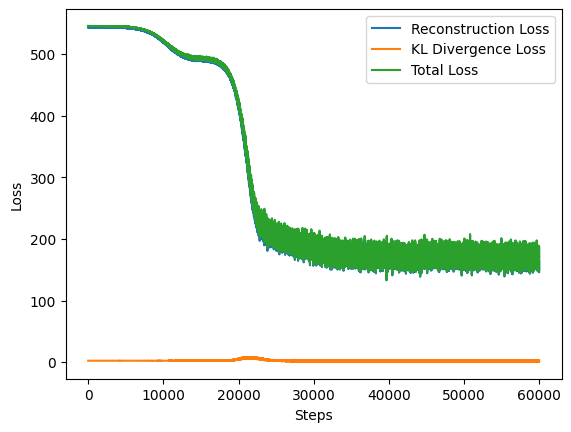

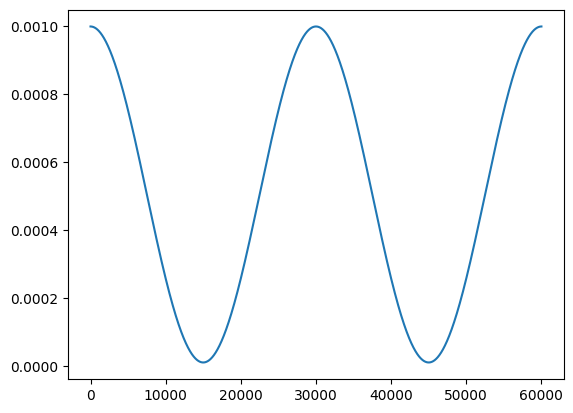

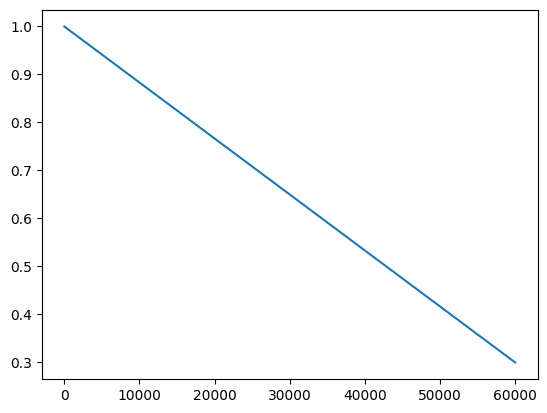

In [4]:
dataset, encoder, decoder = train_and_plot(dataset_name, hidden_dim_1, hidden_dim_2, batch_size, epochs, initial_lr, temperature, final_temperature)

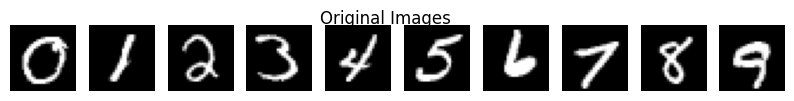

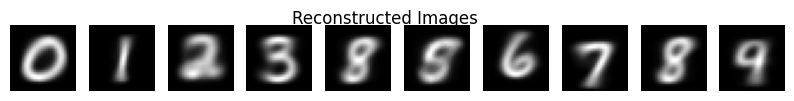

In [5]:
import random

def visualize_images(images, num_classes, title):
    fig, axes = plt.subplots(1, num_classes, figsize=(num_classes, 1))
    for i in range(num_classes):
        axes[i].imshow(images[i][0], cmap='gray')
        axes[i].axis('off')
    # plt.subplots_adjust(wspace=0.2, hspace=0.8)
    plt.suptitle(title)
    plt.show()

def sample_and_reconstruct(dataset, encoder, decoder, input_dim, num_classes, temperature):
    samples_per_class = 1
    original_images = [[] for _ in range(num_classes)]
    reconstructed_images = [[] for _ in range(num_classes)]
    selected_classes = [False] * num_classes
    
    with torch.no_grad():
        for x, y in random.sample(list(dataset), len(dataset)): # Shuffle dataset
            if all(selected_classes):
                break
            if selected_classes[y]:
                continue
            x = x.view(-1, input_dim)
            logits = encoder(x)
            z = gumbel_softmax(logits, temperature)
            x_recon = decoder(z)
            original_images[y].append(x.view(28, 28).numpy())
            reconstructed_images[y].append(x_recon.view(28, 28).numpy())
            selected_classes[y] = True

    visualize_images(original_images, num_classes, 'Original Images')
    visualize_images(reconstructed_images, num_classes, 'Reconstructed Images')


# 调用函数
sample_and_reconstruct(dataset, encoder, decoder, input_dim=28*28, num_classes=10, temperature=0.5)


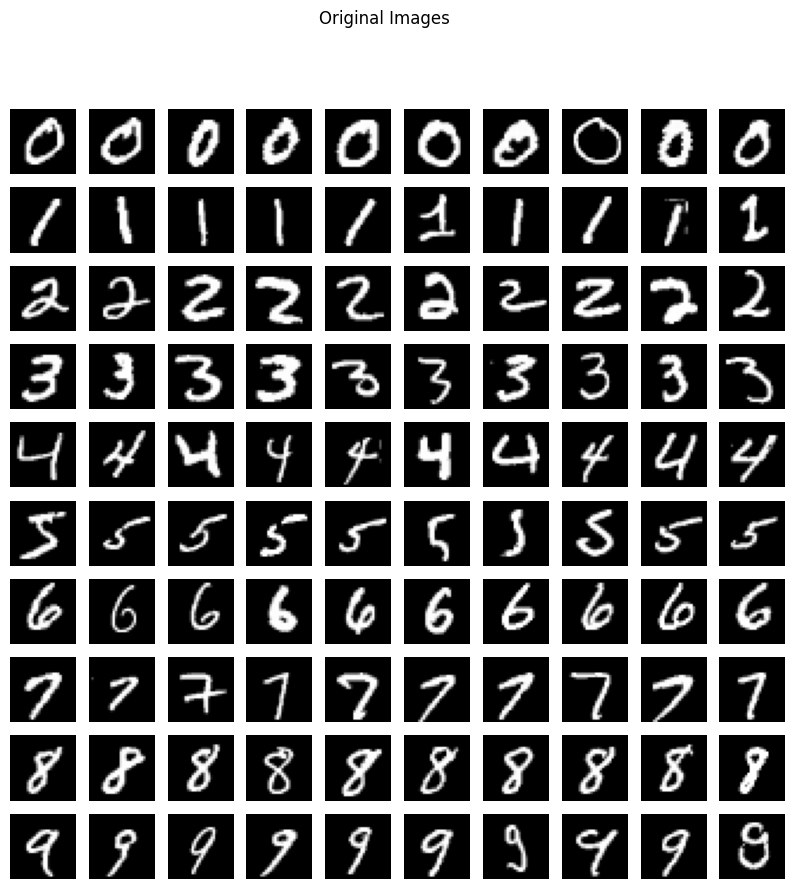

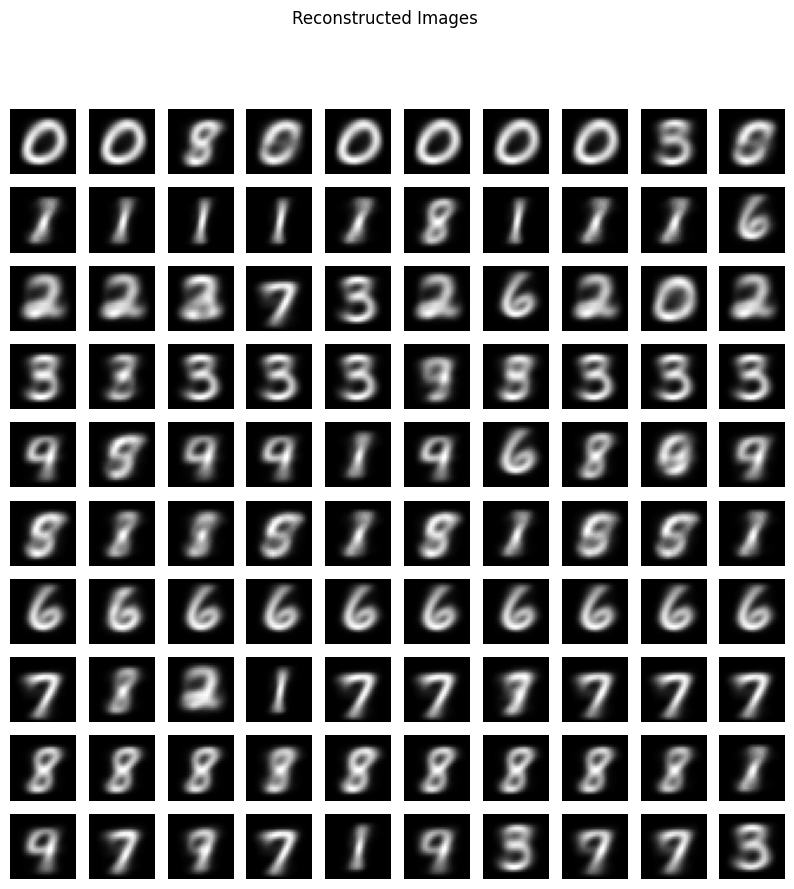

In [6]:
samples_per_class = 10
input_dim = 28 * 28
num_classes = 10
original_images = [[] for _ in range(num_classes)]
reconstructed_images = [[] for _ in range(num_classes)]

with torch.no_grad():
    for x, y in dataset:
        if all(len(images) >= samples_per_class for images in original_images):
            break
        x = x.view(-1, input_dim)
        logits = encoder(x)
        z = gumbel_softmax(logits, temperature)
        x_recon = decoder(z)
        original_images[y].append(x.view(28, 28).numpy())
        reconstructed_images[y].append(x_recon.view(28, 28).numpy())

fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(10, 10))
for i in range(num_classes):
    for j in range(samples_per_class):
        axes[i, j].imshow(original_images[i][j], cmap='gray')
        axes[i, j].axis('off')
plt.suptitle('Original Images')
plt.show()

fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(10, 10))
for i in range(num_classes):
    for j in range(samples_per_class):
        axes[i, j].imshow(reconstructed_images[i][j], cmap='gray')
        axes[i, j].axis('off')
plt.suptitle('Reconstructed Images')
plt.show()

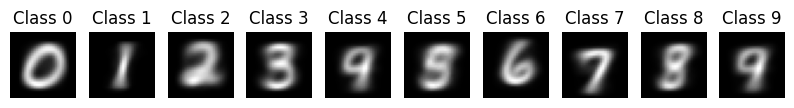

In [7]:
# Generate from latent vector
categorical_dim = 10
input_dim = 28 * 28
temperature = 0.5

def generate_from_latent(dataset, encoder, decoder, categorical_dim, temperature):
    # init
    latent_sums = torch.zeros(categorical_dim, categorical_dim)
    class_counts = torch.zeros(categorical_dim, dtype=torch.int)

    # calculate the sum of latent vectors for each class
    with torch.no_grad():
        for img, label in dataset:
            img = img.view(-1, input_dim)
            logits = encoder(img)
            z = gumbel_softmax(logits, temperature).squeeze()
            latent_sums[label] += z
            class_counts[label] += 1

    # calculate the average latent vector for each class
    avg_latent_vector = latent_sums / class_counts[:, None]

    fig, axes = plt.subplots(1, categorical_dim, figsize=(categorical_dim, 1))

    # plot for each class
    for i in range(categorical_dim):
        generated_img = decoder(avg_latent_vector[i])
        generated_img = generated_img.view(28, 28).detach().cpu().numpy()  # 转换为numpy数组
        ax = axes[i]
        ax.imshow(generated_img, cmap='gray')
        ax.set_title(f'Class {i}')
        ax.axis('off')

    # apply transformations to EMNIST images
    if dataset_name == 'EMNIST':
        from scipy.ndimage import rotate
        plt.close(fig)  # 关闭原始图像
        rows = 5
        cols = 10
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
        # fig.subplots_adjust(hspace=0.2, wspace=0.2)  # 调整子图间的间距
        fig.suptitle('Generated EMNIST Images (rotated and flipped)')

        for i in range(categorical_dim):
            row = i // cols
            col = i % cols
            generated_img = decoder(avg_latent_vector[i])
            generated_img = generated_img.view(28, 28).detach().cpu().numpy()
            generated_img = rotate(generated_img, -90)  # 逆时针旋转90度
            generated_img = np.fliplr(generated_img)  # 水平镜像
            ax = axes[row, col]
            ax.imshow(generated_img, cmap='gray')
            ax.set_title(f'Class {i}')
            ax.axis('off')
        # 隐藏多余的子图
        for i in range(categorical_dim, rows * cols):
            row = i // cols
            col = i % cols
            axes[row, col].axis('off')
        fig.tight_layout()

    plt.show()

generate_from_latent(dataset, encoder, decoder, categorical_dim=10, temperature=0.5)
# # init
# latent_sums = torch.zeros(categorical_dim, categorical_dim)
# class_counts = torch.zeros(categorical_dim, dtype=torch.int)

# # calculate the sum of latent vectors for each class
# with torch.no_grad():
#     for img, label in dataset:
#         img = img.view(-1, input_dim)
#         logits = encoder(img)
#         z = gumbel_softmax(logits, temperature).squeeze()
#         latent_sums[label] += z
#         class_counts[label] += 1

# # calculate the average latent vector for each class
# avg_latent_vector = latent_sums / class_counts[:, None]

# fig, axes = plt.subplots(1, categorical_dim, figsize=(categorical_dim, 1))

# # plot for each class
# for i in range(categorical_dim):
#     generated_img = decoder(avg_latent_vector[i])
#     generated_img = generated_img.view(28, 28).detach().cpu().numpy()  # 转换为numpy数组
#     ax = axes[i]
#     ax.imshow(generated_img, cmap='gray')
#     ax.set_title(f'Class {i}')
#     ax.axis('off')

# # apply transformations to EMNIST images
# if dataset_name == 'EMNIST':
#     from scipy.ndimage import rotate
#     plt.close(fig)  # 关闭原始图像
#     rows = 5
#     cols = 10
#     fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
#     # fig.subplots_adjust(hspace=0.2, wspace=0.2)  # 调整子图间的间距
#     fig.suptitle('Generated EMNIST Images (rotated and flipped)')

#     for i in range(categorical_dim):
#         row = i // cols
#         col = i % cols
#         generated_img = decoder(avg_latent_vector[i])
#         generated_img = generated_img.view(28, 28).detach().cpu().numpy()
#         generated_img = rotate(generated_img, -90)  # 逆时针旋转90度
#         generated_img = np.fliplr(generated_img)  # 水平镜像
#         ax = axes[row, col]
#         ax.imshow(generated_img, cmap='gray')
#         ax.set_title(f'Class {i}')
#         ax.axis('off')
#     # 隐藏多余的子图
#     for i in range(categorical_dim, rows * cols):
#         row = i // cols
#         col = i % cols
#         axes[row, col].axis('off')
#     fig.tight_layout()

# plt.show()


/Users/YUAN/opt/anaconda3/envs/myCVAE/lib/python3.11/site-packages/torch/nn/functional.py:1892: UserWarning: `eps` parameter is deprecated and has no effect.
  warnings.warn("`eps` parameter is deprecated and has no effect.")


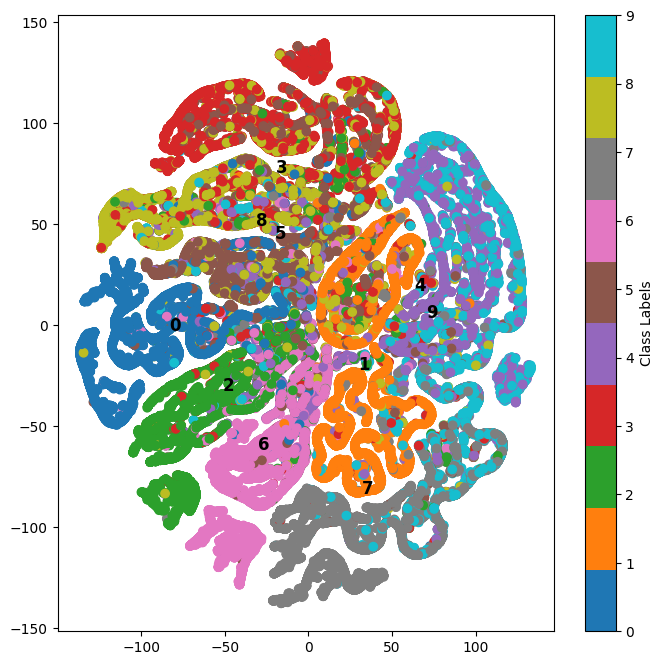

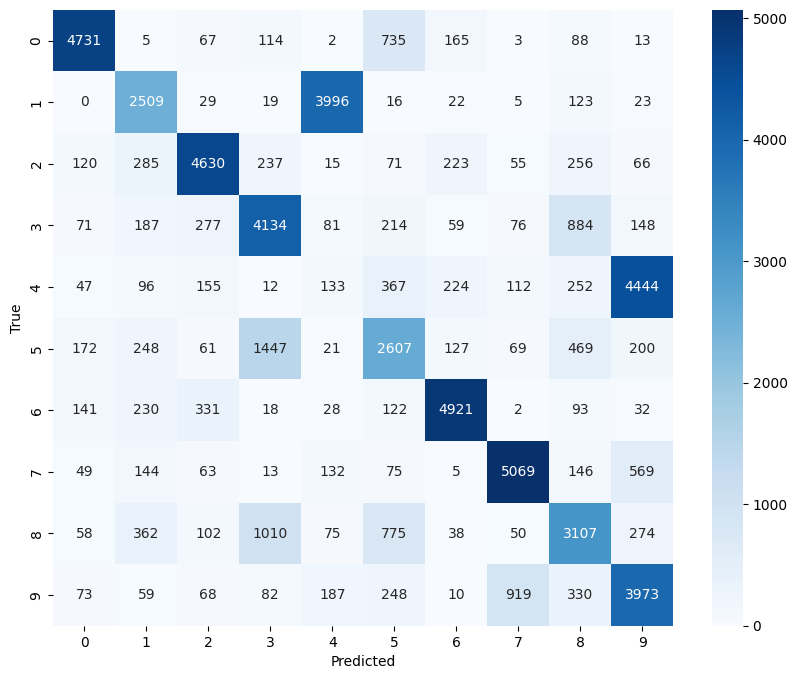

Rand index:  0.4652236719003795


In [8]:
from sklearn.manifold import TSNE
import numpy as np
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

def visualize_latent(encoder, dataloader, num_classes=10, temperature=1.0):
    # init
    latent_vectors = torch.empty(0, categorical_dim)
    Y = torch.empty(0, dtype=torch.long)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # send dataset to encoder
    with torch.no_grad():
        for x, y in dataloader:
            x = x.view(-1, input_dim)
            logits = encoder(x)
            z = gumbel_softmax(logits, temperature)
            latent_vectors = torch.cat([latent_vectors, z])
            Y = torch.cat([Y, y])

    # convert latent vectors to numpy arrays
    latent_vectors = latent_vectors.cpu().numpy()
    Y = Y.cpu().numpy()

    # run t-SNE on latent vectors to get 2D embedding
    tsne = TSNE(n_components=2)
    latent_vectors_2d = tsne.fit_transform(latent_vectors)

    # plot 2D embedding
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], c=Y, cmap='tab10')
    if dataset_name == 'EMNIST':
        scatter = plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], c=Y, cmap='tab20')
    plt.colorbar(scatter, label='Class Labels')
    for i in range(num_classes):
        centroid = np.mean(latent_vectors_2d[Y == i], axis=0)
        plt.text(centroid[0], centroid[1], str(i), color='black', fontsize=12, fontweight='bold', ha='center', va='center')
    plt.show()

    # cm
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    # find the most likely label for each test input
    predicted_labels = latent_vectors.argmax(axis=1)

    # calculate the confusion matrix
    cm = confusion_matrix(Y, predicted_labels)

    # plot the confusion matrix
    plt.figure(figsize=(10, 8))
    if dataset_name == 'EMNIST':
        plt.figure(figsize=(50, 40))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # calculate accuracy
    from sklearn.metrics import adjusted_rand_score
    rand_index = adjusted_rand_score(Y, predicted_labels)
    print("Rand index: ", rand_index)

visualize_latent(encoder, dataloader, num_classes=10, temperature=0.5)
# # init
# latent_vectors = torch.empty(0, categorical_dim)
# Y = torch.empty(0, dtype=torch.long)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# # send dataset to encoder
# with torch.no_grad():
#     for x, y in dataloader:
#         x = x.view(-1, input_dim)
#         logits = encoder(x)
#         z = gumbel_softmax(logits, temperature)
#         latent_vectors = torch.cat([latent_vectors, z])
#         Y = torch.cat([Y, y])

# # convert latent vectors to numpy arrays
# latent_vectors = latent_vectors.cpu().numpy()
# Y = Y.cpu().numpy()

# # run t-SNE on latent vectors to get 2D embedding
# tsne = TSNE(n_components=2)
# latent_vectors_2d = tsne.fit_transform(latent_vectors)

# # plot 2D embedding
# plt.figure(figsize=(8, 8))
# scatter = plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], c=Y, cmap='tab10')
# if dataset_name == 'EMNIST':
#     scatter = plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], c=Y, cmap='tab20')
# plt.colorbar(scatter, label='Class Labels')
# for i in range(num_classes):
#     centroid = np.mean(latent_vectors_2d[Y == i], axis=0)
#     plt.text(centroid[0], centroid[1], str(i), color='black', fontsize=12, fontweight='bold', ha='center', va='center')
# plt.show()


In [9]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# # find the most likely label for each test input
# predicted_labels = latent_vectors.argmax(axis=1)

# # calculate the confusion matrix
# cm = confusion_matrix(Y, predicted_labels)

# # plot the confusion matrix
# plt.figure(figsize=(10, 8))
# if dataset_name == 'EMNIST':
#     plt.figure(figsize=(50, 40))
# sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()


In [10]:
# # Rand-index
# from sklearn.metrics import adjusted_rand_score
# rand_index = adjusted_rand_score(Y, predicted_labels)
# print("Rand index: ", rand_index)